In [144]:
#G050.2213-00.6063
#19:25:57.52 15:03:00.3
#3.3 kpc
#Band 6 ALMA
#CH3OH (methanol)

In [145]:
# For Colab
!pip install -Uq peakutils
!pip install -Uq lineid_plot
!pip install -Uq astroquery
!pip install -Uq lmfit
!wget https://github.com/saint-germain/rot_diag/raw/main/G050.2213-00.6063.csv

--2025-07-15 21:20:33--  https://github.com/saint-germain/rot_diag/raw/main/G050.2213-00.6063.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/saint-germain/rot_diag/main/G050.2213-00.6063.csv [following]
--2025-07-15 21:20:33--  https://raw.githubusercontent.com/saint-germain/rot_diag/main/G050.2213-00.6063.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400384 (391K) [text/plain]
Saving to: ‘G050.2213-00.6063.csv.1’

G050.2213-00.6063.c 100%[===================>] 391.00K  --.-KB/s    in 0.007s  

2025-07-15 21:20:33 (54.9 MB/s) - ‘G050.2213-00.6063.csv.1’ saved [400384/400384]



In [146]:
from astroquery.linelists.cdms import CDMS
import astropy.units as u
import astropy.constants as c
import peakutils
from peakutils.plot import plot as pplot
import matplotlib.pyplot as plt
import pandas as pd
import lineid_plot
from lmfit.models import GaussianModel
import numpy as np
from scipy.optimize import curve_fit

In [147]:
# search in CDMS database for plausible CH3OH lines in relevant range (see slides)
min_frequency=241.67
max_frequency=241.91
response = CDMS.query_lines(min_frequency= min_frequency* u.GHz,
                            max_frequency=max_frequency * u.GHz,
                            molecule="032504 CH3OH, vt=0-2",
                            get_query_payload=False,temperature_for_intensity=0)

In [148]:
line_wave=response['FREQ']/1e3 # MHz to GHz
line_label=[str(i) for i in line_wave] # line label for plotting

In [149]:
fname='G050.2213-00.6063.csv'
df = pd.read_csv(fname)
freq=df['Freq'] # in GHz
i_nu=df['Intensity'] # in Jy sr^-1

Text(321.33333333333337, 0.5, 'Intensity (Jy sr^-1)')

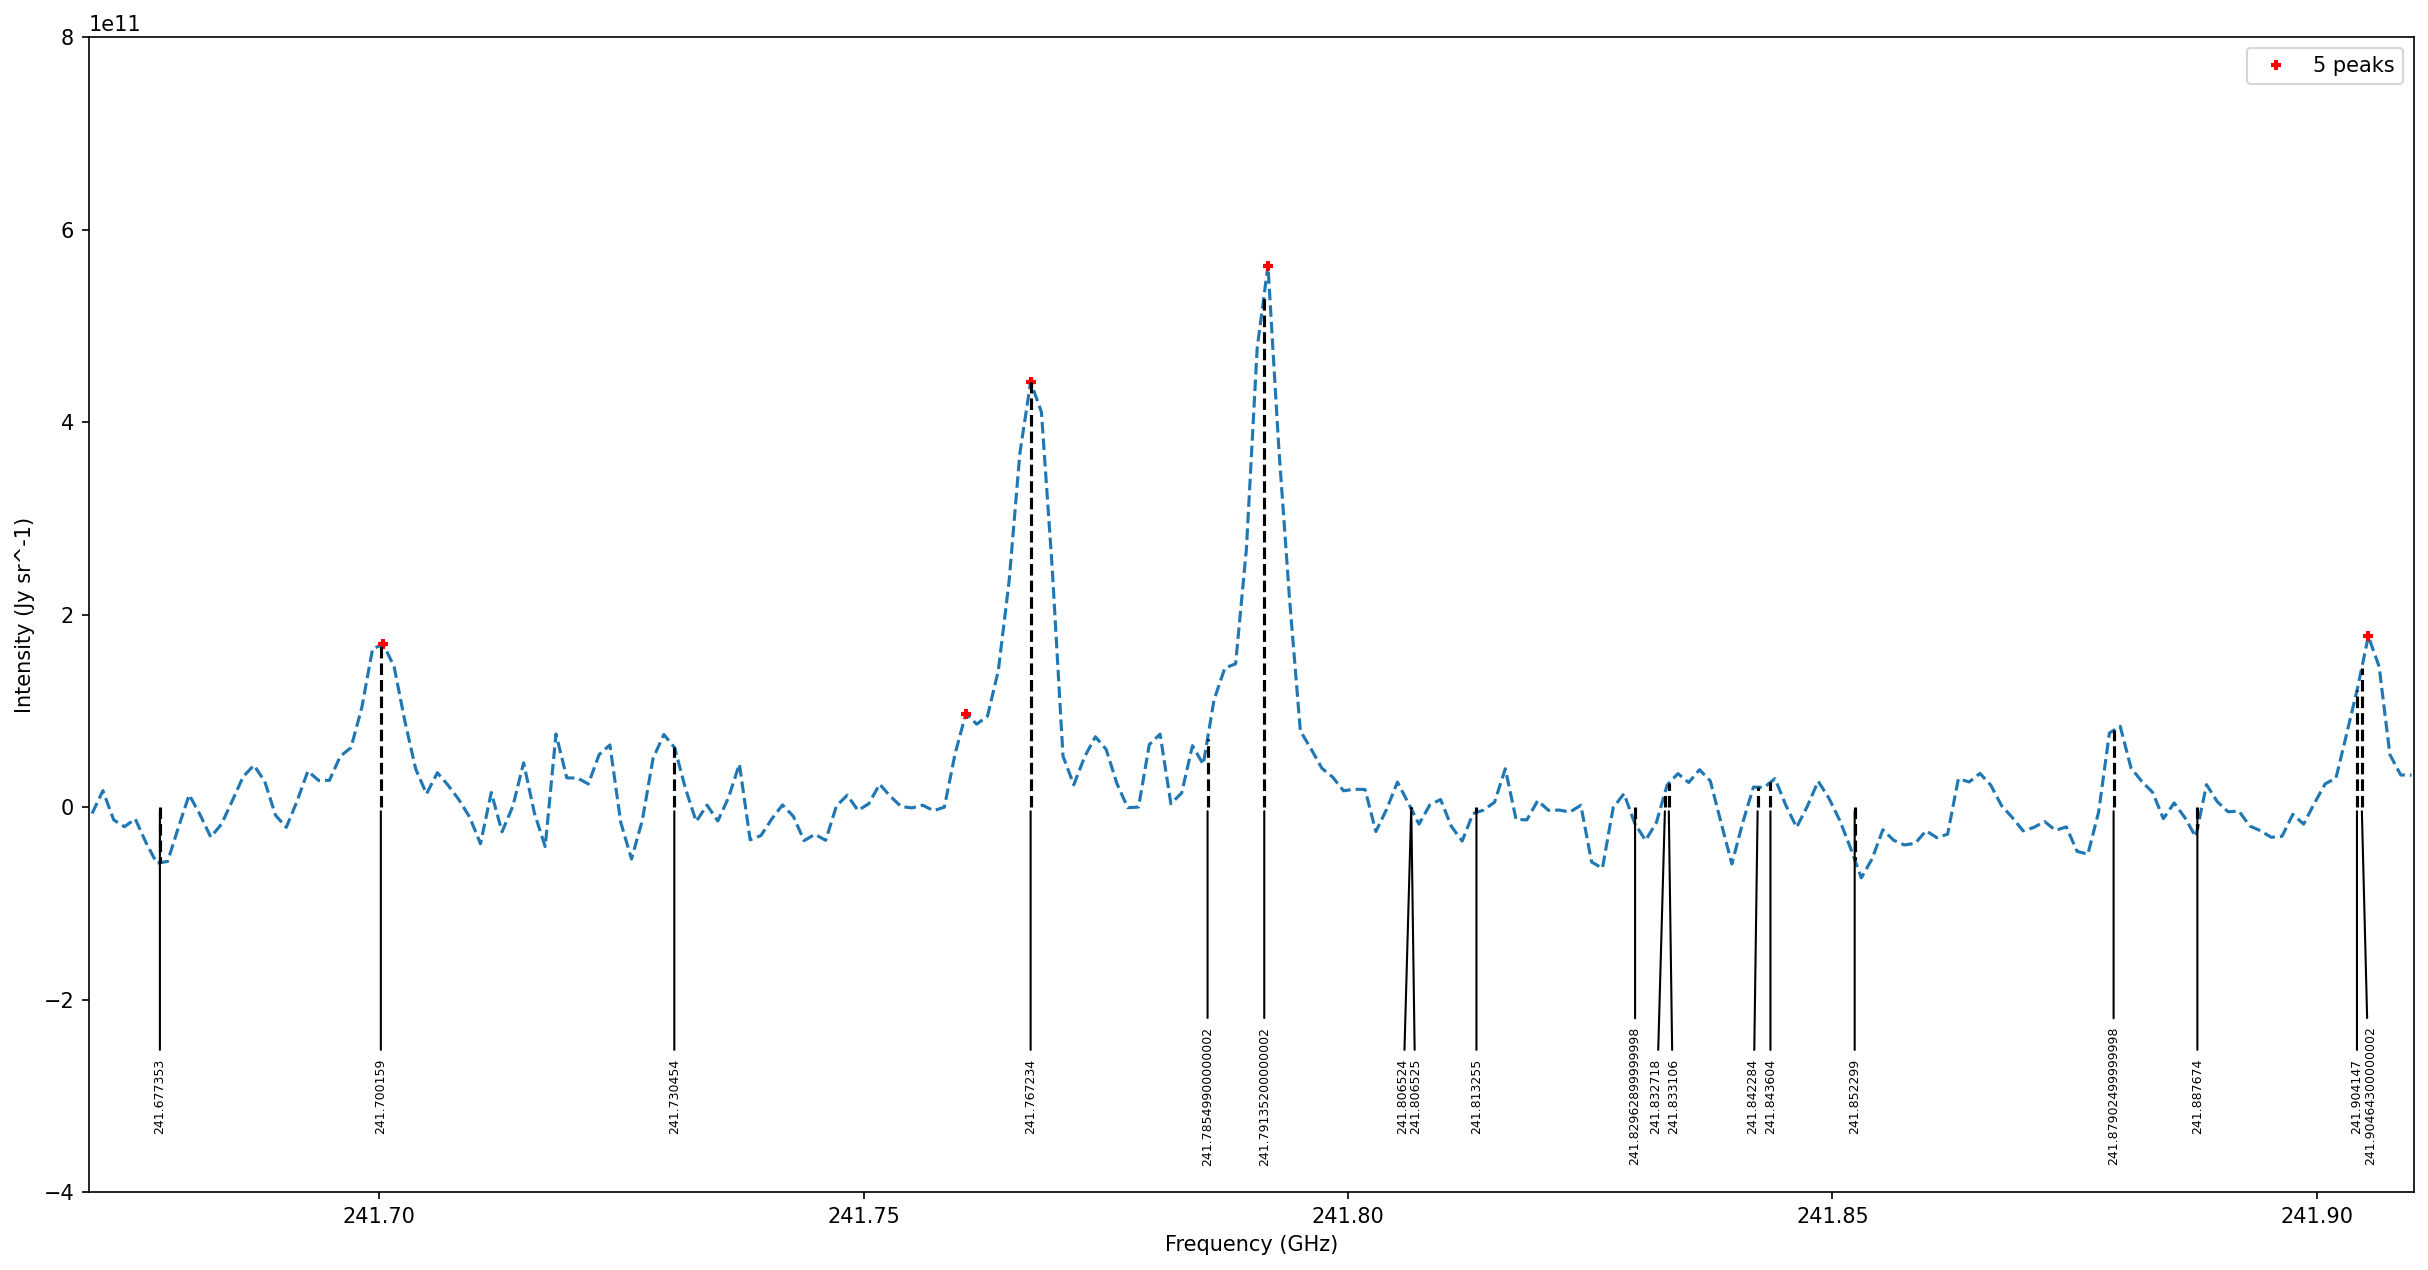

In [150]:
# plot cropped spectrum + plausible line locations
# peakutils is only used here as a visual aid

filter=(freq>min_frequency)&(freq<max_frequency)
freqn=freq[filter]
i_nun=i_nu[filter]

indices = peakutils.indexes(i_nun, thres=0.25, min_dist=0.1)  # indices are the "peak" positions
fig, ax = plt.subplots(figsize=(20,10),dpi=150)

pplot(freqn, i_nun, indices)
ax.set_xlim(min_frequency,max_frequency)
ax.set_ylim(-4e11,0.8e12)
lineid_plot.plot_line_ids(freqn, i_nun, line_wave, line_label, ax=ax, arrow_tip=0, box_loc=-3e11, max_iter=300, label1_size=6) # locate theoretical lines from cdms query
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Intensity (Jy sr^-1)')

In [151]:
# make a gaussian model for each plausible line using lmfit
for i,j in zip(line_wave,range(len(line_wave))):
  gausstemp=GaussianModel(prefix='g'+str(j)+'_')

npeaks=len(line_wave)
model=GaussianModel(prefix='g1_')
for i in range(1,npeaks):
  model=model+GaussianModel(prefix='g%d_' % (i+1))
pars=model.make_params()
for i,ff in zip(range(npeaks),line_wave):
  pars['g%d_center' % (i+1)].set(value=ff,vary=False) # fix nu_ul
  pars['g%d_sigma' % (i+1)].set(value=0.01, min=1e-3,max=0.02)
  pars['g%d_amplitude' % (i+1)].set(value=0.01, min=0,max=5e14)

In [152]:
out=model.fit(i_nun,pars,x=freqn) # run fitting algorithm
comps = out.eval_components(x=freqn) # fit results for each line

/usr/local/lib/python3.11/dist-packages/uncertainties/core.py:1024: UserWarning:

Using UFloat objects with std_dev==0 may give unexpected results.



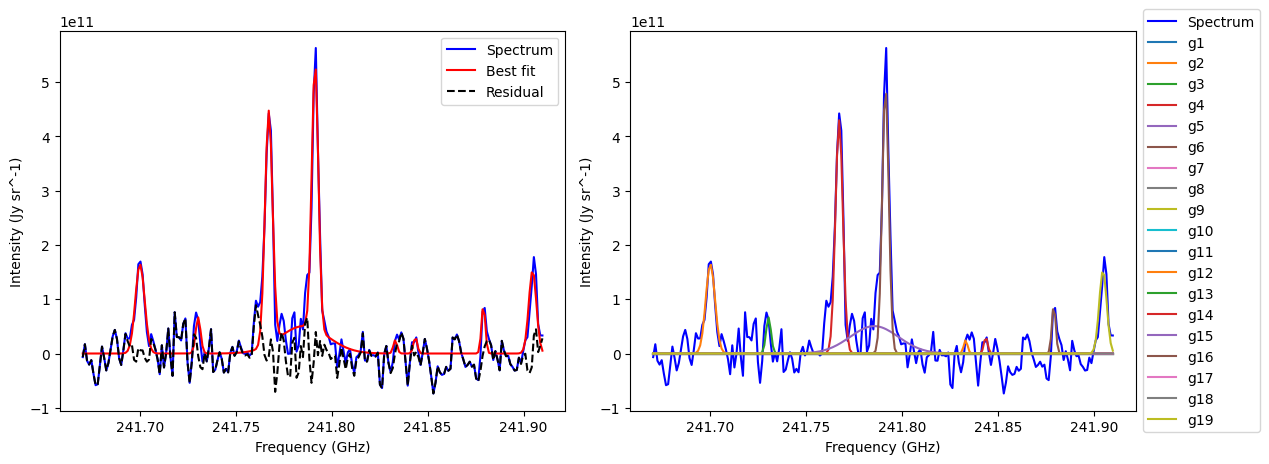

In [153]:
# plot left: data,model,residuals
# plot right: plot each line fit
x=freqn
y=i_nun

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
axes[0].plot(x, y, 'b',label='Spectrum')
axes[0].plot(x, out.best_fit, 'r-', label='Best fit')
axes[0].plot(x, out.residual, 'k--', label='Residual')
axes[0].legend(loc='best')
axes[0].set_xlabel('Frequency (GHz)')
axes[0].set_ylabel('Intensity (Jy sr^-1)')


axes[1].plot(x, y, 'b',label='Spectrum')
for i in range(npeaks):
  axes[1].plot(x, comps['g%d_' % (i+1)], label='g'+str(i+1))

axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[1].set_xlabel('Frequency (GHz)')
axes[1].set_ylabel('Intensity (Jy sr^-1)')

plt.tight_layout()

In [154]:
# save line parameters:
# frequency, eup, aul, gup, i dnu integral
# GHz, K, s^-1, N/A, Jy*sr^-1*GHz
elo=response['ELO']*1.43*u.K*u.cm # cm**-1 to K
etrans=line_wave*0.04799*u.K/u.MHz # GHz**-1 to K
eup=elo+etrans

Aul=10**response['LGAIJ']
gup=response['GUP']

dnu=freqn.iloc[1]-freqn.iloc[0]
integ_txt=[np.trapz(comps['g%d_'%(i+1)],dx=dnu) for i in range(npeaks)]

mydict={'Freq':line_wave,'Eup':eup,'Aul':Aul,'gup':gup,'I dv':integ_txt}
df_txt = pd.DataFrame(mydict)
df_txt.to_csv('line_parameters.csv', index=False)

/tmp/ipython-input-154-3005655019.py:12: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



In [155]:
df_txt

,Freq,Eup,Aul,gup,I dv
0,241.677353,1060.077099,8.997047e-08,100,7.062544e+03
1,241.700159,47.712697,6.035316e-05,44,9.990372e+08
2,241.730454,582.067541,6.519285e-09,180,2.129676e+08
3,241.767234,40.215423,5.806307e-05,44,2.096212e+09
4,241.785499,1153.844815,2.697118e-08,188,1.594039e+09
5,241.791352,34.674472,6.045051e-05,44,2.101316e+09
6,241.806524,114.528545,2.180218e-05,44,7.710693e+03
7,241.806525,114.528545,2.180218e-05,44,7.710693e+03
8,241.813255,122.043804,2.177208e-05,44,3.703868e+03
9,241.829629,130.089484,2.189778e-05,44,7.710693e+03


In [156]:
# GOAL A
# use parameters to calculate N_u in cm^-2
# make rotational diagram (log-log)
# eup < 500 K; log(n_u/g_ul) > 26
# fit straight line
# use slope to calculate T in K, T ~ 15 K

In [157]:
# get partition function to obtain N_CH3OH
result = CDMS.get_species_table()
mol = result[result['tag'] == 32504]
mol.pprint(max_width=160)

 tag     molecule          Name       #lines lg(Q(1000)) lg(Q(500)) lg(Q(300)) ... lg(Q(9.375)) lg(Q(5.000)) lg(Q(2.725)) Ver. Documentation Date of entry Entry
----- ------------- ----------------- ------ ----------- ---------- ---------- ... ------------ ------------ ------------ ---- ------------- ------------- -----
32504 CH3OH, vt=0-2 CH3OH, vt = 0  2  38643      5.5413     5.0092     4.5685 ...       1.8931       1.4268       1.0752   3*   e032504.cat      May 2016    --


In [158]:
mol

tag,molecule,Name,#lines,lg(Q(1000)),lg(Q(500)),lg(Q(300)),lg(Q(225)),lg(Q(150)),lg(Q(75)),lg(Q(37.5)),lg(Q(18.75)),lg(Q(9.375)),lg(Q(5.000)),lg(Q(2.725)),Ver.,Documentation,Date of entry,Entry
int64,str27,str34,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str11,str10,str11
32504,"CH3OH, vt=0-2","CH3OH, vt = 0  2",38643,5.5413,5.0092,4.5685,4.322,3.989,3.466,2.9642,2.4393,1.8931,1.4268,1.0752,3*,e032504.cat,May 2016,--


In [159]:
# fit interpolation function to partition function data
# check that it's ok near T

In [160]:
# GOAL B
# use interpolated partition function to calculate N_CH3OH ~ 1.5e15 cm^-2



---



---

**Nombre:** Sebastián Numpaque

**Documento:** C. C. 1002396960

## **Solution**

### **Goal A)**

$$\int I_\nu\,d\nu\approx\frac{h\nu}{4\pi}A_{ul}N_
{ul}$$

In [161]:
# Variable Values
h_planck = c.h

E_up = df_txt['Eup']*u.K

g_up = df_txt['gup'].values

nu = df_txt['Freq'].values*u.GHz

A_ul = df_txt['Aul'].values/u.s

I_dnu = df_txt['I dv'].values*u.Jy*u.GHz

N_u = (4*np.pi*I_dnu/(A_ul*h_planck*nu)).to(u.cm**-2)

In [162]:
# Data Selection
condition = (E_up > 0) & (E_up < 500) & (np.log(N_u.value/g_up) > 26)

E_up = E_up[condition]
N_u = N_u[condition]
g_up = g_up[condition]

# Linear Fit
linear_fit = lambda x, a, b: a*x + b

slope, intercept = curve_fit(linear_fit, E_up, np.log(N_u.value/g_up))[0]

# Temperature
T_rot = -1/slope

print(f"Slope m = {slope}")
print(f'Temperature T = {T_rot} K')

Slope m = -0.06434993876519177
Temperature T = 15.540030327751003 K


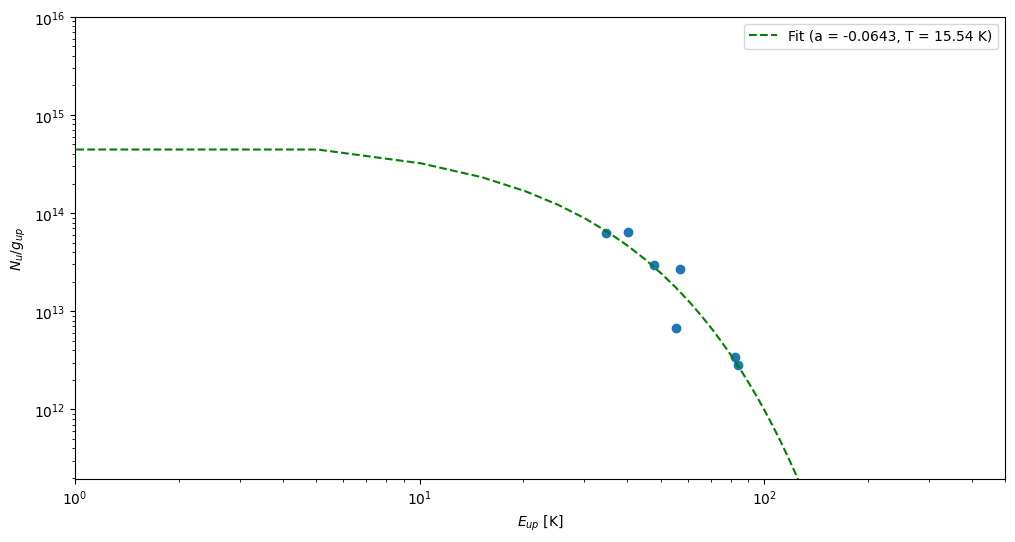

In [163]:
plt.figure(figsize = (12, 6))

plt.scatter(E_up, N_u/g_up)


plt.xscale('log')
plt.yscale('log')

plt.xlim(1, 500)
plt.ylim(np.exp(26), 1e16)

plt.xlabel('$E_{up}$ [K]')
plt.ylabel('$N_u/g_{up}$')

# Linear Fit
x_fit = np.linspace(0, 500, 100)
y_fit = np.exp(intercept + slope*x_fit)

plt.plot(x_fit, y_fit, color='green', linestyle='--',
         label=f'Fit (a = {slope:.4f}, T = {T_rot:.2f} K)')


plt.legend()
plt.show()

### **Goal B**

$$N=Q(T_R)e^a$$

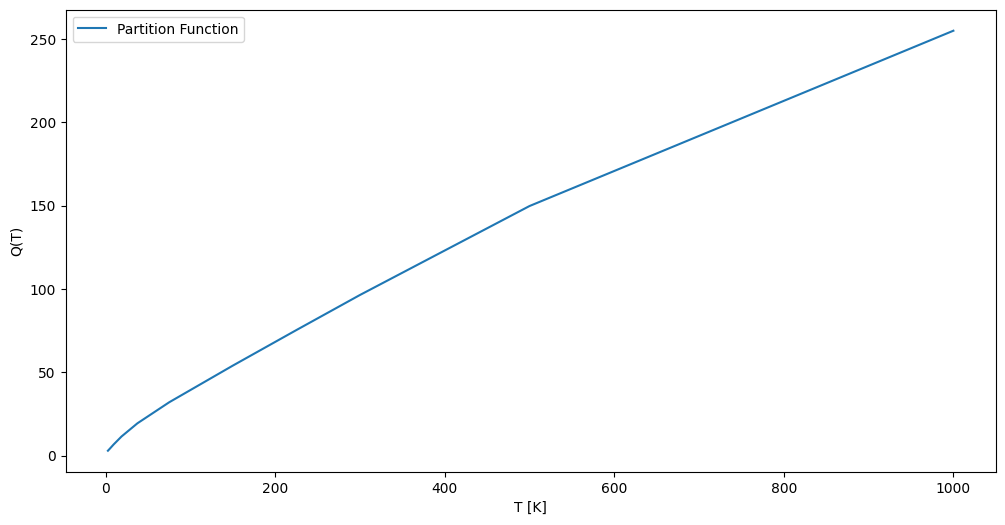

In [164]:
# Temperature and Q Partition
Ts_partition = mol._meta['Temperature (K)']
Q_partition = np.exp(mol[mol.colnames[4:15]].to_pandas().iloc[0].values)

# Plotting
plt.figure(figsize = (12, 6))

plt.plot(Ts_partition, Q_partition, label = 'Partition Function')

plt.xlabel('T [K]')
plt.ylabel('Q(T)')

plt.legend()

plt.show()

In [165]:
# For Interpolation
from scipy.interpolate import interp1d

In [174]:
# Interpolation
Q_interp = interp1d(Ts_partition, Q_partition,
                    kind = 'linear',  fill_value = "extrapolate")

Q_15 = Q_interp(T_rot)

# Column Density
N_methanol = Q_15*np.exp(intercept)*u.cm**-2

print(f'N(1e15) CH3OH = {N_methanol/1e15}')

N(1e15) CH3OH = 6.034947464534097 1 / cm2
